##### Copyright 2018 The TensorFlow Authors.

In [42]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [43]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 回归：预测燃油的效率

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

在*回归*问题中，我们旨在预测出类似价格或概率这样连续的输出。相对于一个*分类*问题，我们的目标是从一系列分类中选择出一个分类（例如，给出一张包含苹果或橘子图片，识别出图片中有水果）。

本笔记本使用经典的[Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)数据集，建立了一个用来预测70年代末到80年代初汽车的燃油效率模型。为了做到这一点，我们将为该模型提供很多那个时期的汽车描述。这些描述包括：气缸数、排量、马力和重量。

此示例使用`tf.keras`这个API，相关的细节，请参阅[本指南]（https://www.tensorflow.org/guide/keras）。

In [44]:
# 使用 seaborn 绘图
!pip install seaborn

/usr/bin/sh: 1: pip: not found


In [45]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

!pip install tensorflow==2.0.0-beta1
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/usr/bin/sh: 1: pip: not found
2.0.0-beta0


## Auto MPG数据集

该数据集可从[UCI机器学习库](https://archive.ics.uci.edu/ml/)中获得。


### 获取数据
首先下载数据集。

In [46]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/echo/.keras/datasets/auto-mpg.data'

使用 pandas 导入它。

In [47]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 数据清洗

数据集中包含一些未知值(Na)。

In [48]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

为了保证这个示例的简单，请删除这些行。

In [49]:
dataset = dataset.dropna()

`"Origin"`列实际上是明确的，而不仅仅是一个数字。所以要把它转换成one-hot：

In [50]:
origin = dataset.pop('Origin')

In [51]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 将数据拆分为训练集和测试集

现在将数据集拆分为一个训练集和一个测试集。

我们稍后将对模型使用测试集进行评估。

In [52]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 检查数据

快速查看训练集中几对列的联合分布。

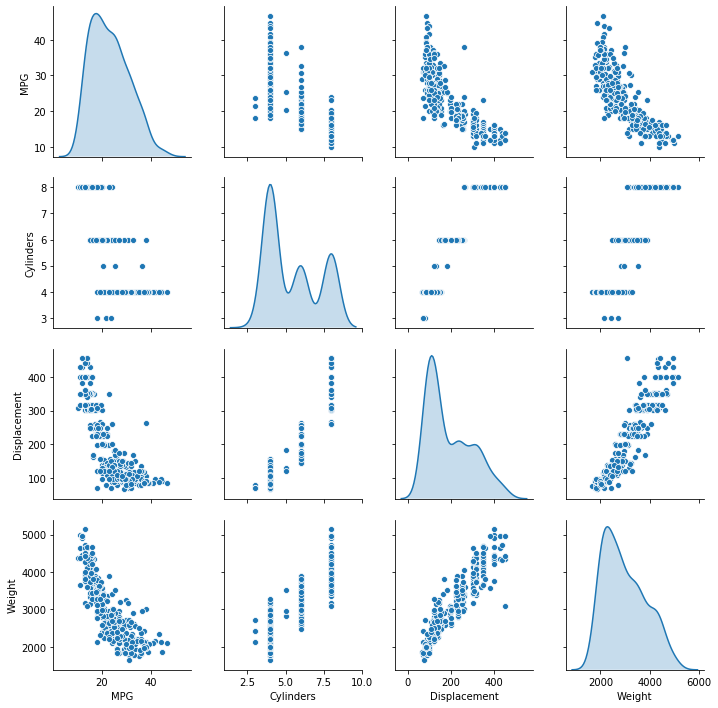

In [53]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


也可以查看总体的统计数据：

In [54]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 从标签中分离特征

将目标值或“标签”与特征分开。这个标签是你训练模型用来预测的值。

In [55]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 规范化数据

再次查看上方`train_stats`这一部分，注意每个特征的范围有多大。

规范化使用不同尺度和范围的特征是一个很好的实践。虽然模型*可能*在没有规范化特征的情况下收敛，但它使训练变得更加困难，并且使生成的模型依赖于所用输入单元的选择。

注意：尽管我们有意只从训练集生成这些统计信息，但这些统计信息也将用于规范测试集。这样我们才能将测试集映射到与模型训练时相同的分布中。

In [56]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

我们将使用这些规范化的数据来训练模型。

注意：这里用于规范化输入的统计数据(平均值和标准差)需要应用于任何输入到模型的数据，以及我们前面所做的one-hot编码。这包括在生产中使用模型时的测试集和实时数据。

## 模型

### 建模

让我们建立我们的模型。在这里，我们将使用一个具有两个紧密相连的隐藏层的`Sequential`模型，以及一个返回单个连续值的输出层。模型构建步骤被包装在一个`build_model`函数中，因为稍后我们将创建第二个模型。

In [57]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [58]:
model = build_model()

### 检查模型

使用 `.summary` 方法来打印输出模型的简单描述。

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


现在试试这个模型。从训练数据中选取`10`个例子，并对它们调用`model.predict`方法。

In [60]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.01460259],
       [ 0.01353029],
       [-0.5038407 ],
       [ 0.11898422],
       [-0.19109635],
       [-0.1809409 ],
       [-0.23663732],
       [-0.19415888],
       [-0.24784186],
       [-0.52692246]], dtype=float32)

它似乎有效，并产生预期形状和类型的结果。

### 训练模型

对模型进行1000个周期的训练，并在`history`对象中记录训练过程并验证其准确性。

In [ ]:
# 每个训练周期都会打印一个点来显示训练过程
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................

使用`history`对象中存储的统计信息来可视化模型的训练进度。

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

此图显示在大约100个周期后，误差非但没有改善，甚至出现恶化。因此我们更新`model.fit`调用，以便在验证误差没有改善时自动停止训练。我们将使用*EarlyStopping callback*测试每个周期的训练条件。如果在一个设定的时间段内的训练没有改善，那么就会自动停止训练。

您可以在[此处](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/earlystopping)了解有关此回调的更多信息。

In [ ]:
model = build_model()

# patience 参数是检查改善周期量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

图表显示，在验证集上，平均误差通常在+/-2 MPG左右。这个结果好吗？我们留给您去判决。

让我们看看模型通过使用我们在训练时没有使用的**测试**集进行归纳的效果。这会告诉我们，在实际我们使用这个模型的效果会有多么好。

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

### 预测

最后，使用测试集中的数据预测油耗(MPG)数值：

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


看来我们的模型预测得相当好。让我们再来看看错误分布。

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

它不是完全的高斯分布，但我们可以推断出，是样本数量非常少导致的。

## 结论

本笔记介绍了一些处理回归问题的技术。

* 均方误差(MSE)是处理回归问题常用的损失函数（分类问题中使用不同的损失函数）。
* 同样，用于回归的评估指标与分类不同。一个常见的回归指标是平均绝对误差 (MAE)。
* 当数字的输入数据特征的值具有不同范围时，每个特征应独立缩放到相同的范围。
* 如果没有太多的训练数据，一种方法是选择一个隐藏层很少的小网络，以避免过度拟合。
* 早期停止是防止过度拟合的一种有效的技术。